<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/458_Assignment2_CNNsandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the following code we will set up both dense neural networks and convolutional neural networks to classify images of articles of clothing from the Fashion MNIST dataset into ten classes. We will set up five different experiments in order to explore the impact different nodes on the network and to determine what features in the images are detected by the nodes. 


Notebook uses portions of code written by Edward Arroyo and Daniel Jensen

##Setup and Preprocessing

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0-tf'

In [3]:
tf.__version__

'2.2.0-rc4'

In [4]:
from keras import metrics
from tensorflow.keras import models
from tensorflow.keras import layers

Using TensorFlow backend.


In [0]:
# neccessary for K.gradient to work in TensorFlow 2.x
# only needed for the "Finding a pattern the hidden node maximally responds to" section below.
# but disabled to make Tensorboard work...
tf.compat.v1.disable_eager_execution() 

In [0]:
# Set see in order to achieve consistent results across runs
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Import Fashion-MNIST dataset

Using data from collected from European fasion platform Zalondo. The dataset has been compiled to mimic the structure of the MNIST dataset. It consists of 60,000 training images and 10,000 testing images. All of the images are in grayscale and 28x28 pixels. Each of the images is labeled with an integer 0-9 that corresponds to the following classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

More information can be found here: https://github.com/zalandoresearch/fashion-mnist 

In [7]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [8]:
#Store copy of training images in order to easily view images even after transformations are performed
example_train_images = train_images.copy()
example_train_images.shape

(60000, 28, 28)

In [9]:
# The distribution of the classes appears to be uniform
from collections import Counter
Counter(train_labels).most_common()

[(9, 6000),
 (0, 6000),
 (3, 6000),
 (2, 6000),
 (7, 6000),
 (5, 6000),
 (1, 6000),
 (6, 6000),
 (4, 6000),
 (8, 6000)]

In [0]:
# https://github.com/zalandoresearch/fashion-mnist
# https://www.tensorflow.org/tutorials/keras/classification

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Example of a single sample, a 28x28 pixel image of an article of clothing

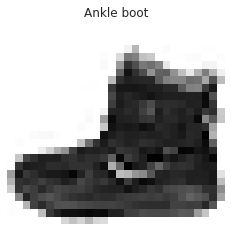

In [11]:
#https://matplotlib.org/tutorials/colors/colormaps.html?highlight=colormap
plt.imshow(train_images[0], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

### Prepare the data


In [0]:
# Reshape the data into the shape that the network expects
train_images = train_images.reshape((60000, 28, 28, 1))

# Scale the data to [0,1] interval
train_images = train_images.astype('float32') / 255

# Do the same for the test dataset
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

Set aside 5,000 samples from the training data to use as the validation set.

In [0]:
val_images, train_images = train_images[:5000], train_images[5000:]
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

#Experiment 5 Baseline: 32, pool, 64, pool
Toying with conv dimensions


##Build and compile the model


In [0]:
model = models.Sequential()
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
#keras.utils.plot_model(model, show_shapes=True)

### Create a callback to get training times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

##Train the model

In [17]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100, 
                    validation_data=(val_images, val_labels))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 8s 143us/sample - loss: 0.6665 - accuracy: 0.7517 - val_loss: 0.4011 - val_accuracy: 0.8546
Epoch 2/20
55000/55000 [==============================] - 8s 144us/sample - loss: 0.4182 - accuracy: 0.8444 - val_loss: 0.3098 - val_accuracy: 0.8840
Epoch 3/20
55000/55000 [==============================] - 8s 144us/sample - loss: 0.3532 - accuracy: 0.8690 - val_loss: 0.2753 - val_accuracy: 0.8986
Epoch 4/20
55000/55000 [==============================] - 8s 144us/sample - loss: 0.3148 - accuracy: 0.8838 - val_loss: 0.2623 - val_accuracy: 0.9044
Epoch 5/20
55000/55000 [==============================] - 8s 144us/sample - loss: 0.2913 - accuracy: 0.8940 - val_loss: 0.2449 - val_accuracy: 0.9092
Epoch 6/20
55000/55000 [==============================] - 8s 143us/sample - loss: 0.2809 - accuracy: 0.8955 - val_loss: 

In [18]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

172.042142

## Test the model

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [20]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.22699325796365738, 0.9216)

In [21]:
test_time = test_rt.process_time
test_time # in seconds

0.675763

### Create a dataframe for the training and test statistics

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.204064,0.923127,0.206987,0.9226
16,0.201347,0.924273,0.210524,0.9248
17,0.195908,0.925855,0.208647,0.9194
18,0.193977,0.926473,0.205100,0.9224
19,0.192344,0.927236,0.201182,0.9252


In [24]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','CNN (4 layers), padding1') # model name appears first
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['training time (sec)'] = train_time    
results_df['testing time (sec)'] = test_time      # testing time appears last
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), padding1",0.192344,0.927236,0.201182,0.9252,0.226993,0.9216,172.042142,0.675763


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

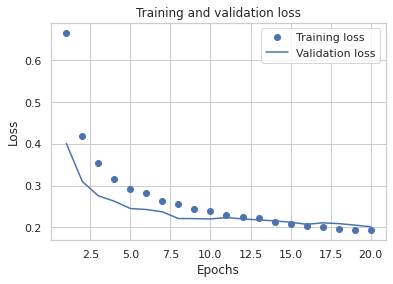

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

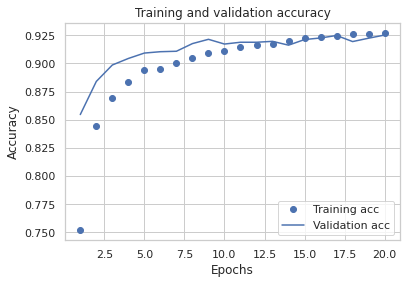

In [26]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 6
64, pool, 32, pool

##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [29]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 500,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 8s 141us/sample - loss: 0.8318 - accuracy: 0.6918 - val_loss: 0.4770 - val_accuracy: 0.8374
Epoch 2/20
55000/55000 [==============================] - 8s 137us/sample - loss: 0.4795 - accuracy: 0.8233 - val_loss: 0.3758 - val_accuracy: 0.8676
Epoch 3/20
55000/55000 [==============================] - 8s 136us/sample - loss: 0.3947 - accuracy: 0.8524 - val_loss: 0.3315 - val_accuracy: 0.8788
Epoch 4/20
55000/55000 [==============================] - 8s 137us/sample - loss: 0.3550 - accuracy: 0.8688 - val_loss: 0.3023 - val_accuracy: 0.8880
Epoch 5/20
55000/55000 [==============================] - 8s 136us/sample - loss: 0.3308 - accuracy: 0.8769 - val_loss: 0.2811 - val_accuracy: 0.8934
Epoch 6/20
55000/55000 [==============================] - 8s 137us/sample - loss: 0.3118 - accuracy: 0.8833 - val_loss: 0.2694 - val_accuracy: 0.9002
Epoch 7/20
55000/55000 [===========================

In [30]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

153.062832

## Test the model

In [31]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.20193207468390464, 0.9253)

In [32]:
test_time = test_rt.process_time
test_time # in seconds

0.683993

##Add training and test statistics to results dataframe

In [33]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.202594,0.923745,0.188741,0.9264
16,0.197234,0.926291,0.186984,0.9294
17,0.192334,0.928673,0.185335,0.9270
18,0.186202,0.930582,0.184533,0.9280
19,0.179967,0.932836,0.178328,0.9320


In [34]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), padding2') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), padding2",0.179967,0.932836,0.178328,0.932,0.201932,0.9253,153.062832,0.683993


In [35]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (4 layers), padding1",0.192344,0.927236,0.201182,0.9252,0.226993,0.9216,172.042142,0.675763
1,"CNN (4 layers), padding2",0.179967,0.932836,0.178328,0.9320,0.201932,0.9253,153.062832,0.683993


## Plotting the performance 

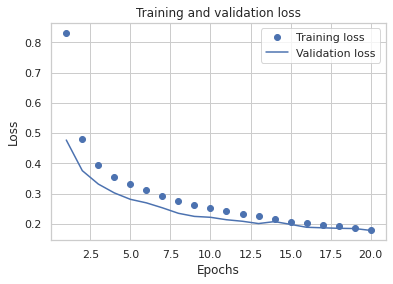

In [36]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

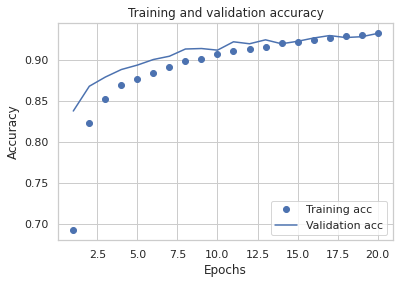

In [37]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [38]:
# save the model
model.save("experiment4")

INFO:tensorflow:Assets written to: experiment4/assets


#Experiment 7
32, 64, pool


##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.ZeroPadding2D(3))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu',))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [41]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 200,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 9s 171us/sample - loss: 0.6603 - accuracy: 0.7585 - val_loss: 0.3776 - val_accuracy: 0.8646
Epoch 2/20
55000/55000 [==============================] - 9s 168us/sample - loss: 0.3942 - accuracy: 0.8549 - val_loss: 0.3115 - val_accuracy: 0.8842
Epoch 3/20
55000/55000 [==============================] - 9s 168us/sample - loss: 0.3326 - accuracy: 0.8774 - val_loss: 0.2732 - val_accuracy: 0.9032
Epoch 4/20
55000/55000 [==============================] - 9s 168us/sample - loss: 0.2970 - accuracy: 0.8914 - val_loss: 0.2469 - val_accuracy: 0.9078
Epoch 5/20
55000/55000 [==============================] - 9s 167us/sample - loss: 0.2730 - accuracy: 0.8989 - val_loss: 0.2339 - val_accuracy: 0.9116
Epoch 6/20
55000/55000 [==============================] - 9s 167us/sample - loss: 0.2552 - accuracy: 0.9061 - val_loss: 0.2241 - val_accuracy: 0.9126
Epoch 7/20
55000/55000 [===========================

In [42]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

185.7948

## Test the model

In [43]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.20191777453422546, 0.9285)

In [44]:
test_time = test_rt.process_time
test_time # in seconds

0.716905

##Add training and test statistics to results dataframe

In [45]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.174870,0.934491,0.185879,0.9282
16,0.170486,0.936509,0.189609,0.9292
17,0.165239,0.936564,0.182748,0.9328
18,0.159685,0.939636,0.183497,0.9298
19,0.157452,0.939255,0.177916,0.9302


In [46]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), padding3') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), padding3",0.157452,0.939255,0.177916,0.9302,0.201918,0.9285,185.7948,0.716905


In [47]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (4 layers), padding1",0.192344,0.927236,0.201182,0.9252,0.226993,0.9216,172.042142,0.675763
1,"CNN (4 layers), padding2",0.179967,0.932836,0.178328,0.9320,0.201932,0.9253,153.062832,0.683993
2,"CNN (4 layers), padding3",0.157452,0.939255,0.177916,0.9302,0.201918,0.9285,185.794800,0.716905


## Plotting the performance 

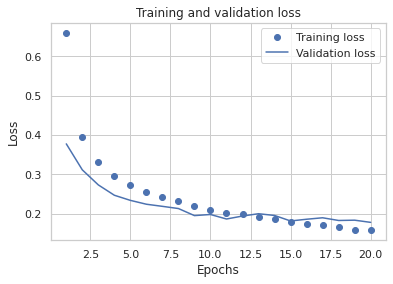

In [48]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

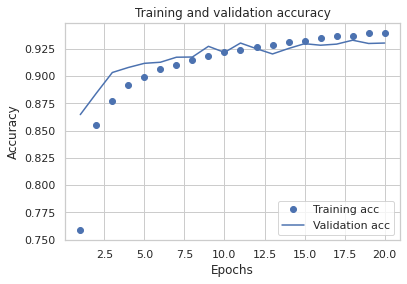

In [49]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 8 
4 layer CNN: 32, 32, pool, 64, 64, pool


##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu',))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [52]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 7s 130us/sample - loss: 0.6604 - accuracy: 0.7527 - val_loss: 0.3972 - val_accuracy: 0.8560
Epoch 2/20
55000/55000 [==============================] - 7s 126us/sample - loss: 0.4117 - accuracy: 0.8470 - val_loss: 0.3082 - val_accuracy: 0.8840
Epoch 3/20
55000/55000 [==============================] - 7s 126us/sample - loss: 0.3462 - accuracy: 0.8721 - val_loss: 0.2740 - val_accuracy: 0.8962
Epoch 4/20
55000/55000 [==============================] - 7s 126us/sample - loss: 0.3104 - accuracy: 0.8855 - val_loss: 0.2557 - val_accuracy: 0.8992
Epoch 5/20
55000/55000 [==============================] - 7s 126us/sample - loss: 0.2888 - accuracy: 0.8944 - val_loss: 0.2337 - val_accuracy: 0.9138
Epoch 6/20
55000/55000 [==============================] - 7s 125us/sample - loss: 0.2732 - accuracy: 0.9000 - val_loss: 0.2320 - val_accuracy: 0.9118
Epoch 7/20
55000/55000 [===========================

In [53]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

139.408252

## Test the model

In [54]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.2072968983232975, 0.9242)

In [55]:
test_time = test_rt.process_time
test_time # in seconds

0.688485

##Add training and test statistics to results dataframe

In [56]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.197392,0.926709,0.195939,0.9260
16,0.195234,0.926527,0.193100,0.9264
17,0.190432,0.928818,0.192911,0.9268
18,0.186837,0.929309,0.197357,0.9242
19,0.185574,0.931291,0.190087,0.9264


In [57]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), no padding') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), no padding",0.185574,0.931291,0.190087,0.9264,0.207297,0.9242,139.408252,0.688485


In [58]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (4 layers), padding1",0.192344,0.927236,0.201182,0.9252,0.226993,0.9216,172.042142,0.675763
1,"CNN (4 layers), padding2",0.179967,0.932836,0.178328,0.9320,0.201932,0.9253,153.062832,0.683993
2,"CNN (4 layers), padding3",0.157452,0.939255,0.177916,0.9302,0.201918,0.9285,185.794800,0.716905
3,"CNN (4 layers), no padding",0.185574,0.931291,0.190087,0.9264,0.207297,0.9242,139.408252,0.688485


## Plotting the performance 

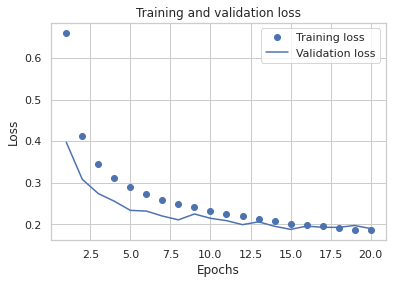

In [59]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

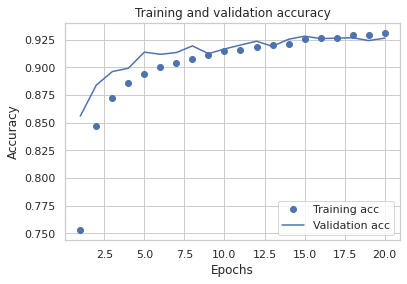

In [60]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 9
64, pool, 128, pool

##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [80]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 50,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 11s 195us/sample - loss: 0.5900 - accuracy: 0.7783 - val_loss: 0.3575 - val_accuracy: 0.8724
Epoch 2/20
55000/55000 [==============================] - 11s 191us/sample - loss: 0.3700 - accuracy: 0.8650 - val_loss: 0.2905 - val_accuracy: 0.8888
Epoch 3/20
55000/55000 [==============================] - 10s 187us/sample - loss: 0.3187 - accuracy: 0.8818 - val_loss: 0.2586 - val_accuracy: 0.9032
Epoch 4/20
55000/55000 [==============================] - 10s 186us/sample - loss: 0.2948 - accuracy: 0.8917 - val_loss: 0.2433 - val_accuracy: 0.9062
Epoch 5/20
55000/55000 [==============================] - 10s 187us/sample - loss: 0.2770 - accuracy: 0.8979 - val_loss: 0.2375 - val_accuracy: 0.9094
Epoch 6/20
55000/55000 [==============================] - 10s 188us/sample - loss: 0.2595 - accuracy: 0.9034 - val_loss: 0.2326 - val_accuracy: 0.9092
Epoch 7/20
55000/55000 [=====================

In [81]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

207.484062

## Test the model

In [82]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.2307373955309391, 0.9186)

In [83]:
test_time = test_rt.process_time
test_time # in seconds

0.701456

##Add training and test statistics to results dataframe

In [84]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.202850,0.923818,0.196684,0.9260
16,0.203499,0.924582,0.202539,0.9218
17,0.199322,0.924636,0.204101,0.9192
18,0.199041,0.925182,0.225544,0.9118
19,0.198670,0.925036,0.202349,0.9222


In [85]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), batch 50') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,"CNN (4 layers), batch 50",0.19867,0.925036,0.202349,0.9222,0.230737,0.9186,207.484062,0.701456


In [86]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (4 layers), padding1",0.187941,0.927727,0.201251,0.9222,0.229840,0.9171,218.069128,0.767908
1,"CNN (4 layers), padding2",0.179156,0.932255,0.182316,0.9306,0.205239,0.9277,191.595804,0.835073
2,"CNN (4 layers), padding3",0.156231,0.940182,0.191817,0.9288,0.211828,0.9259,227.769529,0.834572
3,"CNN (4 layers), no padding",0.186341,0.929618,0.187195,0.9264,0.212949,0.9239,180.984483,0.744917
4,"CNN (4 layers), batch 50",0.198670,0.925036,0.202349,0.9222,0.230737,0.9186,207.484062,0.701456


## Plotting the performance 

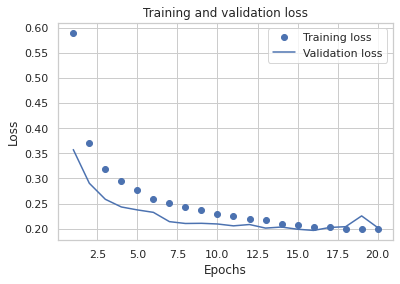

In [87]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

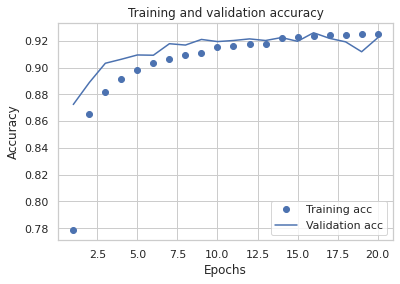

In [88]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [89]:
# save the model
model.save("experiment4")

INFO:tensorflow:Assets written to: experiment4/assets


#Experiment 10
4 layer CNN: 64, 64, pool, 128, 128, pool


##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

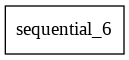

In [78]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [65]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=30,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 9s 165us/sample - loss: 0.5903 - accuracy: 0.7808 - val_loss: 0.3504 - val_accuracy: 0.8724
Epoch 2/30
55000/55000 [==============================] - 9s 159us/sample - loss: 0.3678 - accuracy: 0.8632 - val_loss: 0.2809 - val_accuracy: 0.8962
Epoch 3/30
55000/55000 [==============================] - 9s 159us/sample - loss: 0.3113 - accuracy: 0.8857 - val_loss: 0.2652 - val_accuracy: 0.8984
Epoch 4/30
55000/55000 [==============================] - 9s 158us/sample - loss: 0.2802 - accuracy: 0.8956 - val_loss: 0.2259 - val_accuracy: 0.9144
Epoch 5/30
55000/55000 [==============================] - 9s 158us/sample - loss: 0.2570 - accuracy: 0.9035 - val_loss: 0.2174 - val_accuracy: 0.9202
Epoch 6/30
55000/55000 [==============================] - 9s 158us/sample - loss: 0.2410 - accuracy: 0.9102 - val_loss: 0.2074 - val_accuracy: 0.9222
Epoch 7/30
55000/55000 [===========================

In [66]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

260.749492

In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_3 (ZeroPaddin multiple                  0         
_________________________________________________________________
conv2d_20 (Conv2D)           multiple                  320       
_________________________________________________________________
dropout_25 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_21 (Conv2D)           multiple                  9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling multiple                  0         
_________________________________________________________________
dropout_26 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_22 (Conv2D)           multiple                 

## Test the model

In [67]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.20898484981656074, 0.9324)

In [68]:
test_time = test_rt.process_time
test_time # in seconds

0.543794

##Add training and test statistics to results dataframe

In [69]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
25,0.134879,0.949400,0.180258,0.9356
26,0.132379,0.951491,0.186000,0.9364
27,0.132652,0.949673,0.203803,0.9318
28,0.129548,0.950164,0.181531,0.9372
29,0.127383,0.952945,0.185557,0.9392


In [70]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), padding2, epochs30b') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
29,"CNN (4 layers), padding2, epochs30b",0.127383,0.952945,0.185557,0.9392,0.208985,0.9324,260.749492,0.543794


In [71]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,"CNN (4 layers), padding1",0.192344,0.927236,0.201182,0.9252,0.226993,0.9216,172.042142,0.675763
1,"CNN (4 layers), padding2",0.179967,0.932836,0.178328,0.9320,0.201932,0.9253,153.062832,0.683993
2,"CNN (4 layers), padding3",0.157452,0.939255,0.177916,0.9302,0.201918,0.9285,185.794800,0.716905
3,"CNN (4 layers), no padding",0.185574,0.931291,0.190087,0.9264,0.207297,0.9242,139.408252,0.688485
4,"CNN (4 layers), padding2, epochs30b",0.127383,0.952945,0.185557,0.9392,0.208985,0.9324,260.749492,0.543794


## Plotting the performance 

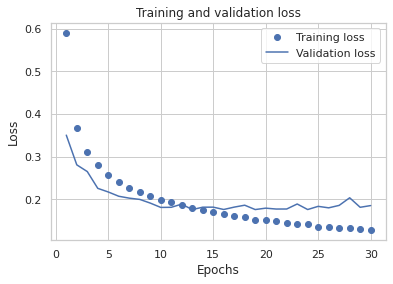

In [72]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

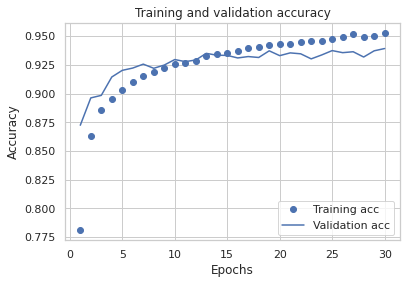

In [73]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Export final results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('A2_4layer-padding.csv')
files.download('A2_4layer-padding.csv')